# Figure 2 and related figures

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

# Our layer definition
with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'

In [3]:
# Load ephys traces

with open('../data/processed/ephys/three_traces.pickle', 'rb') as f:
    three_traces = pickle.load(f)

In [4]:
# Find reconstruction

import os
swcfiles = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/excitatory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/inhibitory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {} .SWC files'.format(len(swcfiles)))
              
for i in np.where(m1.traced)[0]:
    if m1.cells[i] not in swcfiles:
        print('SWC not found: ' + m1.cells[i])
for c in swcfiles:
    if np.sum(m1.cells==c)==0:
        print('Not in the spreadsheet: ' + c + '\n' + swcfiles[c] + '')
    elif ~m1.traced[m1.cells==c]:
        print('Not marked as traced: ' + c)
        
swcfiles_vipdendrites = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/vip_dendrites_only/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles_vipdendrites[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {}  .SWC files for VIP dendrites'.format(len(swcfiles_vipdendrites)))

Found 646 .SWC files
Found 30  .SWC files for VIP dendrites


In [5]:
# Plot one neuron

def plot_swc(file_path, ax, offset=0, depth=500.0, thickness=1000.0,
             dendrite_color='r', axon_color='darkgreen', soma_color='k', 
             s=.05, minwidth=0, soma_s=3):
    
    swc = pd.read_csv(file_path, delim_whitespace=True, comment='#',
                      names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    
    dendrites = swc['type'] == 3
    axons = swc['type'] == 2
    soma = swc['type'] == 1
    
    swc['x'] = swc['x']/thickness
    swc['y'] = swc['y']/thickness
        
    soma_loc = swc.iloc[0][['x', 'y']]
    soma_loc['y'] = soma_loc['y'] + depth/thickness
    
    to_plot = np.zeros_like(dendrites)
    if dendrite_color!='none':
        to_plot |= dendrites
    if axon_color!='none':
        to_plot |= axons
    width = np.max(swc['x'][to_plot]) - np.min(swc['x'][to_plot])
    offset += np.abs(np.min(swc['x'][to_plot]-soma_loc['x']))
    if width < minwidth:
        offset += (minwidth-width)/2
        width = minwidth  
    soma_loc['x'] = soma_loc['x'] - offset
    
    if dendrite_color!='none':
        ax.scatter(swc['x'][dendrites]-soma_loc['x'], swc['y'][dendrites]-soma_loc['y'], 
                   s=s, c=dendrite_color, edgecolors='none', rasterized=True)
    if axon_color!='none':
        ax.scatter(swc['x'][axons]-soma_loc['x'], swc['y'][axons]-soma_loc['y'], 
                s=s, c=axon_color, edgecolors='none', rasterized=True)
    if soma_color!='none':
        ax.scatter(swc['x'][soma]-soma_loc['x'], swc['y'][soma]-soma_loc['y'], 
                s=s, c=soma_color, edgecolors='none', rasterized=True)
    else:
        ax.scatter(offset, -depth/thickness, s=soma_s, c='k', edgecolors='none')
        
    return width


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [6]:
example_neurons = [6, 13, 16, 56, 61, 63, 68, 73, 78, 88, 118, 125, 160, 
                   165, 186, 208, 314, 316, 319, 321, 322, 327, 377, 385, 
                   387, 388, 455, 576, 579, 584, 621, 640, 644, 648, 649, 672, 674, 
                   676, 681, 687, 689, 716, 728, 759, 790, 793, 796, 797, 
                   800, 803, 816, 830, 842, 848, 851, 862, 863, 890, 893, 
                   895, 911, 914, 932, 940, 947, 950, 959, 962, 967, 974, 978, 
                   982, 986, 988, 990, 995, 996, 1003, 1011, 1019, 1020, 
                   1022, 1036, 1039, 1047, 1050, 1066, 1099, 1100, 1106, 
                   1111, 1122, 1123, 1135, 1137, 1169, 1180, 1214, 1224, 
                   1231, 1235, 1237, 1242, 1243, 1250, 1264, 1265, 1266, 
                   1268, 1269, 1285]

example_neurons = np.array(example_neurons) - 1

## Main figure 2

<IPython.core.display.Javascript object>


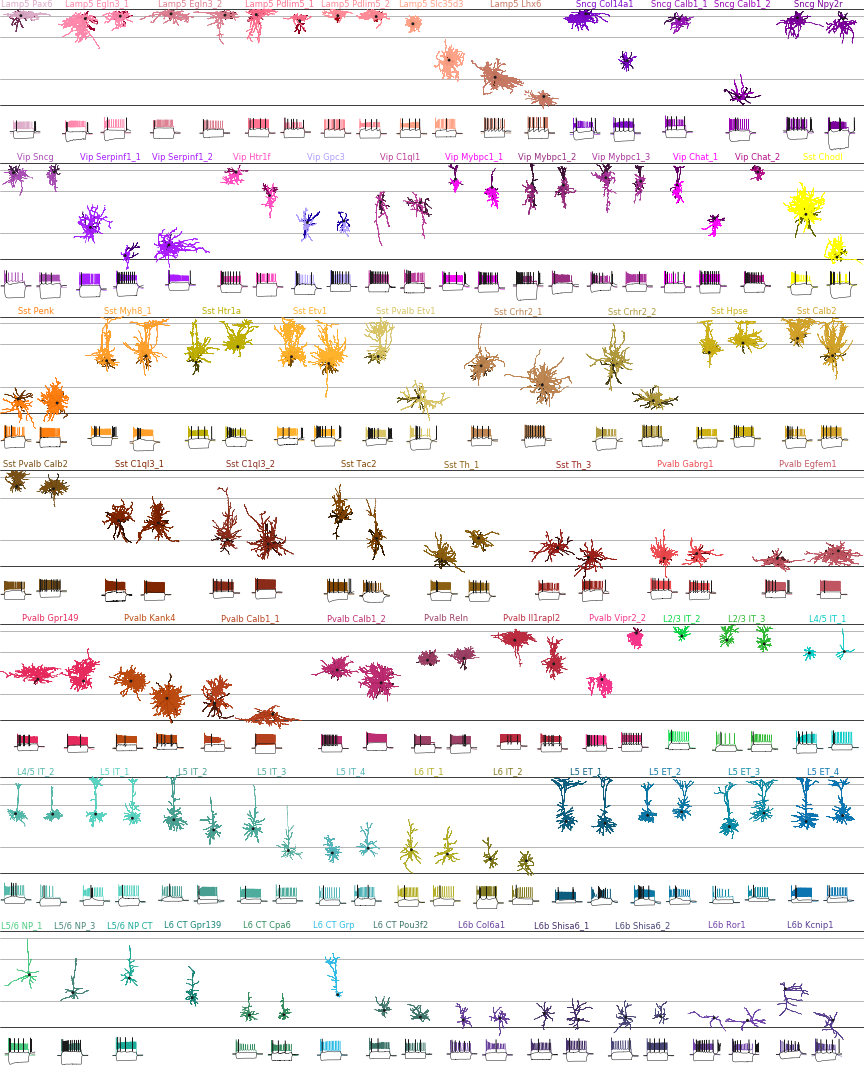

Width: 8.95 cortex thicknesses
Width: 8.98 cortex thicknesses
Width: 8.88 cortex thicknesses
Width: 8.99 cortex thicknesses
Width: 8.99 cortex thicknesses
Width: 8.94 cortex thicknesses
Width: 8.81 cortex thicknesses
Plotted 135 neurons in 73 types.


In [7]:
ephys_width = 0.35
gap = 0.02
rows = 7
cells_per_type = 2
typerowgaps = [.05,.03,.15,.31,.1,.08,.1]
rowoffsets = [.0, .0, .0, .0, .0, .0, .0]

plt.figure(figsize=(7.2, 7.2/9*1.6 * rows))
startnewaxis = True
currentrow = 0

counter_neurons = 0
counter_types = 0

for typ in np.arange(clusterN):
    selection = m1.traced & (ttypes['m1consensus_ass']==typ) & (m1.exclude == '')
    if np.sum(selection)==0:
        continue
        
    col = clusterColors[typ]
    if typ >= np.where(clusterNames=='L2/3 IT_1')[0][0]:
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
        
    if startnewaxis:
        ax = plt.axes([0, (rows-currentrow-1)/rows, 1, 1.0/rows])
        plt.ylim([-1.5,0.1])
        plt.xlim([0,9])
        plt.gca().set_aspect('equal', adjustable='box')
        
        plt.xticks([])
        plt.yticks([])
        sns.despine(ax=ax, left=True, bottom=True)
        for y in [0,1]:
            plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='k')
        for y in [0.07,0.29,0.73]:
            plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')

        w = rowoffsets[currentrow]
        startnewaxis = False
        
    type_center = w
    counter_types += 1
    
    if np.sum(selection)==1:
        t = plt.text(1, -1, clusterNames[typ], color=col, fontsize=5)
        bb = t.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
        labelwidth = bb.transformed(ax.transData.inverted()).width
        t.remove()
        minwidth = max(labelwidth+gap, ephys_width+gap)
    else:
        minwidth = ephys_width+gap
    
    if np.sum(selection[example_neurons])==cells_per_type:
        mychoice = [e for e in example_neurons if selection[e]]
    else:
        mychoice = np.where(selection)[0][:cells_per_type]
        
    for i in mychoice:
        width = plot_swc(swcfiles[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=minwidth,
                          axon_color=ax_col, dendrite_color=den_col, soma_color='none')
        if m1.cells[i] in three_traces:
            time = three_traces[m1.cells[i]][:,3]
            traces = three_traces[m1.cells[i]][:,:3]
            timeinterval = time<=.9
            time = time[timeinterval]
            traces = traces[timeinterval,:]
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,2]/700 - 1.2, color=col, linewidth=.3,
                    rasterized=True)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,1]/700 - 1.2, color='k', linewidth=.3,
                    rasterized=True)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,0]/700 - 1.2, color='k', linewidth=.3,
                    rasterized=True)
            
        w += width
        type_center += width/2
        counter_neurons += 1
        
    plt.text(type_center, 0.03, clusterNames[typ], color=col, fontsize=5, ha='center')
        
    if w>8.2:
        startnewaxis = True
        currentrow += 1
        print('Width: {:.2f} cortex thicknesses'.format(w))
        if currentrow > rows:
            break
    else:
        w += typerowgaps[currentrow]

plt.savefig('../figures/suppfigures/pokemons.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/pokemons_dpi300.pdf', dpi=300)
plt.savefig('../figures/suppfigures/pdf/pokemons_dpi600.pdf', dpi=600)
print('Plotted {} neurons in {} types.'.format(counter_neurons, counter_types))

## All single types in individual files

In [ ]:
%%time

ephys_width = 0.35
gap = 0.02

for typ in range(clusterN):

    selection = (ttypes['m1consensus_ass']==typ) & (m1.exclude == '')
    if np.sum(selection)==0:
        continue
        
    col = clusterColors[typ]
    if typ >= np.where(clusterNames=='L2/3 IT_1')[0][0]:
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
        
    rows = np.ceil(np.sum(selection) / 20)
    fig = plt.figure(figsize=(7.2, 7.2/9*1.6 * rows))
    startnewaxis = True
    currentrow = 0.0
        
    for i in np.concatenate((np.where(m1.traced & selection)[0], np.where(~m1.traced & selection)[0])):
        if startnewaxis:
            ax = plt.axes([0, (rows-currentrow-1)/rows, 1, 1.0/rows])
            plt.ylim([-1.5,0.1])
            plt.xlim([0,9])
            plt.gca().set_aspect('equal', adjustable='box')
        
            plt.xticks([])
            plt.yticks([])
            sns.despine(ax=ax, left=True, bottom=True)
            for y in [0,1]:
                plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='k')
            for y in [0.07,0.29,0.73]:
                plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
            
            if currentrow==0:
                plt.text(0.03, 0.03, clusterNames[typ], color=col, fontsize=5)

            w = 0
            startnewaxis = False
    
        if m1.traced[i]:
            width = plot_swc(swcfiles[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=ephys_width+gap,
                          axon_color=ax_col, dendrite_color=den_col, soma_color='none')
        else:
            if m1.cells[i] in swcfiles_vipdendrites:
                width = plot_swc(swcfiles_vipdendrites[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=ephys_width+gap,
                          axon_color='none', dendrite_color=den_col, soma_color='none')
            else:
                ax.scatter(w + ephys_width/2, -m1.depth[i]/m1.thickness[i], s=3, c='k', edgecolors='none')
                width = ephys_width+gap
    
        if m1.cells[i] in three_traces:
            time = three_traces[m1.cells[i]][:,3]
            traces = three_traces[m1.cells[i]][:,:3]
            timeinterval = time<=.9
            time = time[timeinterval]
            traces = traces[timeinterval,:]
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,2]/700 - 1.2, color=col, linewidth=.3)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,1]/700 - 1.2, color='k', linewidth=.3)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,0]/700 - 1.2, color='k', linewidth=.3)
            
        plt.text(w + width/2, -0.98, '{:.2f}'.format(ttypes['confidence'][i]),
                 color='k', fontsize=5, ha='center')
        
        if (i in example_neurons) or (m1.traced[i] and (np.sum(m1.traced & selection)<=2)):
            plt.text(w + width/2, -1.1, i+1, color='w', fontsize=5, ha='center',
                     bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))
        else:
            plt.text(w + width/2, -1.1, i+1, color='k', fontsize=5, ha='center')
            
        w += width
        
        if w>8.2:
#             print('Width: {:.2f} cortex thicknesses'.format(w))
            startnewaxis = True
            currentrow += 1
            assert currentrow <= rows, "Not enough rows!"
            
    bbox = None
    if (currentrow < rows-1) or ((currentrow == rows-1) and startnewaxis):
         bbox =  matplotlib.transforms.Bbox([[0, 7.2/9*1.6],[7.2, 7.2/9*1.6 * rows]])
        
    plt.savefig('../figures/sanity-checks/pretty-neurons/{}.png'.format(
        ''.join(clusterNames[typ].split('/'))), dpi=300, bbox_inches=bbox)
    
    plt.close()

## All t-types as one PDF

In [9]:
%%time

from matplotlib.backends.backend_pdf import PdfPages

ephys_width = 0.35
gap = 0.02

familybreaks = [8, 13, 27, 47, 57, 69, 73, 77]

startnewpage = True
startnewaxis = True
currentrow = 0 #-1
rows = 8
w = 0
startnewtype = True

plt.ioff()
with PdfPages('../figures/suppdocs/allcells.pdf') as pdf:
    for typ in range(clusterN):
        print(typ, end=' ')
        
        if np.isin(typ, familybreaks) and w>0:
            startnewaxis = True
            currentrow += 1
            w = 0
            if currentrow == rows:
                startnewpage = True
                currentrow = 0
                pdf.savefig(dpi=400)
                plt.close()
        
        selection = (ttypes['m1consensus_ass']==typ) & (m1.exclude == '')
        if np.sum(selection)==0:
            continue
        
        col = clusterColors[typ]
        if typ >= np.where(clusterNames=='L2/3 IT_1')[0][0]:
            ax_col = 'none'
            den_col = col
        else:
            ax_col = col
            den_col = [adjust_lightness(col,.4)]
        
#         startnewaxis = True
#         currentrow += 1
#         startnewtype = True
        if w>0:
            w += 1
        else:
            startnewtype = True
                
        if w>8.2:
            startnewtype = True
            startnewaxis = True
            currentrow += 1
            if currentrow == rows:
                startnewpage = True
                currentrow = 0
                pdf.savefig(dpi=400)
                plt.close()
        elif not startnewtype:
            plt.text(w, 0.05, clusterNames[typ], color=col, fontsize=8)
        
#         if currentrow == rows:
#             startnewpage = True
#             currentrow = 0
#             pdf.savefig(dpi=400)
#             plt.close()
        
        list1 = np.where(m1.traced & selection)[0]
        list1 = list1[np.argsort(m1.depth[list1]/m1.thickness[list1])]
        list2 = np.where(~m1.traced & selection)[0]
        list2 = list2[np.argsort(m1.depth[list2]/m1.thickness[list2])]
        
        for i in np.concatenate((list1, list2)):
            if startnewpage:
                plt.figure(figsize=(8.27, 11.69)) # A4
                startnewpage = False

            if startnewaxis:
                h = 7.2/9*1.6 * rows
                ax = plt.axes([(8.27-7.2)/8.27/2,  (11.69-h)/11.69/2 + h/11.69*(rows-currentrow-1)/rows, 
                               7.2/8.27, h/11.69/rows])
                plt.ylim([-1.5,0.1])
                plt.xlim([0,9])
                plt.gca().set_aspect('equal', adjustable='box')
        
                plt.xticks([])
                plt.yticks([])
                sns.despine(ax=ax, left=True, bottom=True)
                for y in [0,1]:
                    plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='k')
                for y in [0.07,0.29,0.73]:
                    plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
            
                if startnewtype:
                    plt.text(0.03, 0.05, clusterNames[typ], color=col, fontsize=8)
                    startnewtype = False
                w = 0
                    
                startnewaxis = False
    
            if m1.traced[i]:
                width = plot_swc(swcfiles[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=ephys_width+gap,
                          axon_color=ax_col, dendrite_color=den_col, soma_color='none')
            else:
                if m1.cells[i] in swcfiles_vipdendrites:
                    width = plot_swc(swcfiles_vipdendrites[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=ephys_width+gap,
                          axon_color='none', dendrite_color=den_col, soma_color='none')
                else:
                    ax.scatter(w + ephys_width/2, -m1.depth[i]/m1.thickness[i], s=3, c='k', edgecolors='none')
                    width = ephys_width+gap
    
            if m1.cells[i] in three_traces:
                time = three_traces[m1.cells[i]][:,3]
                traces = three_traces[m1.cells[i]][:,:3]
                timeinterval = time<=.9
                time = time[timeinterval]
                traces = traces[timeinterval,:]
                plt.plot((time-.5)*ephys_width + w + width/2, traces[:,2]/700 - 1.2, color=col, linewidth=.3)
                plt.plot((time-.5)*ephys_width + w + width/2, traces[:,1]/700 - 1.2, color='k', linewidth=.3)
                plt.plot((time-.5)*ephys_width + w + width/2, traces[:,0]/700 - 1.2, color='k', linewidth=.3)
            
            plt.text(w + width/2, -0.98, '{:.2f}'.format(ttypes['confidence'][i]),
                 color='k', fontsize=5, ha='center')
        
            if (i in example_neurons) or (m1.traced[i] and (np.sum(m1.traced & selection)<=2)):
                plt.text(w + width/2, -1.1, i+1, color='w', fontsize=5, ha='center',
                     bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))
            else:
                plt.text(w + width/2, -1.1, i+1, color='k', fontsize=5, ha='center')
            
            w += width
        
            if w>8.2:
                startnewaxis = True
                currentrow += 1
                w = 0
                if currentrow == rows:                
                    startnewpage = True
                    currentrow = 0
                    pdf.savefig(dpi=400)
                    plt.close()         
    
    if typ==clusterN-1 and (currentrow>0 or w>0):
        pdf.savefig(dpi=400)
                    
plt.ion()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 CPU times: user 2min 29s, sys: 2.57 s, total: 2min 32s
Wall time: 2min 31s


## Interneurons using Tasic-2018 nomenclature

In [9]:
example_neurons_tasic = example_neurons.copy() + 1

example_neurons_tasic = np.concatenate((example_neurons_tasic, 
    [1305,1031,550,886,633,1274,679,585,366,994,970,864,1188,904,
     981,588,540,438,655]))
example_neurons_tasic = [a for a in example_neurons_tasic if a not in 
    [932,1020,793,803,1019,1036,1137,1135,988,388]]

example_neurons_tasic = np.array(example_neurons_tasic) - 1

In [ ]:
%%time

tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))

ephys_width = 0.35
gap = 0.02

for typ in range(60):

    selection = (ttypes['tasic_ass']==typ) & (m1.exclude == '')
    if np.sum(selection)==0:
        continue
        
    col = tasic2018['clusterColors'][typ]
    ax_col = col
    den_col = [adjust_lightness(col,.4)]
        
    rows = np.ceil(np.sum(selection) / 20)
    plt.figure(figsize=(7.2, 7.2/9*1.6 * rows))
    startnewaxis = True
    currentrow = 0.0
        
    for i in np.concatenate((np.where(m1.traced & selection)[0], np.where(~m1.traced & selection)[0])):
        if startnewaxis:
            ax = plt.axes([0, (rows-currentrow-1)/rows, 1, 1.0/rows])
            plt.ylim([-1.5,0.1])
            plt.xlim([0,9])
            plt.gca().set_aspect('equal', adjustable='box')
        
            plt.xticks([])
            plt.yticks([])
            sns.despine(ax=ax, left=True, bottom=True)
            for y in [0,1]:
                plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='k')
            for y in [0.07,0.29,0.73]:
                plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
            
            if currentrow==0:
                plt.text(0.03, 0.03, tasic2018['clusterNames'][typ], color=col, fontsize=5)

            w = 0
            startnewaxis = False
    
        if m1.traced[i]:
            width = plot_swc(swcfiles[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=ephys_width+gap,
                          axon_color=ax_col, dendrite_color=den_col, soma_color='none')
        else:
            ax.scatter(w + ephys_width/2, -m1.depth[i]/m1.thickness[i], s=3, c='k', edgecolors='none')
            width = ephys_width+gap
    
        if m1.cells[i] in three_traces:
            time = three_traces[m1.cells[i]][:,3]
            traces = three_traces[m1.cells[i]][:,:3]
            timeinterval = time<=.9
            time = time[timeinterval]
            traces = traces[timeinterval,:]
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,2]/700 - 1.2, color=col, linewidth=.3)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,1]/700 - 1.2, color='k', linewidth=.3)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,0]/700 - 1.2, color='k', linewidth=.3)
            
        tasicConf = ttypes['tasic_ass_boot'][i,ttypes['tasic_ass'][i].astype(int)]
        plt.text(w + width/2, -0.98, '{:.2f}'.format(tasicConf),
                 color='k', fontsize=5, ha='center')
        
        if (i in example_neurons_tasic) or (m1.traced[i] and (np.sum(m1.traced & selection)<=2)):
            plt.text(w + width/2, -1.1, i+1, color='w', fontsize=5, ha='center',
                     bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))
        else:
            plt.text(w + width/2, -1.1, i+1, color='k', fontsize=5, ha='center')
            
        w += width
        
        if w>8.2:
#             print('Width: {:.2f} cortex thicknesses'.format(w))
            startnewaxis = True
            currentrow += 1
            assert currentrow <= rows, "Not enough rows!"
            
    bbox = None
    if (currentrow < rows-1) or ((currentrow == rows-1) and startnewaxis):
         bbox =  matplotlib.transforms.Bbox([[0, 7.2/9*1.6],[7.2, 7.2/9*1.6 * rows]])
        
    plt.savefig('../figures/sanity-checks/pretty-interneurons-tasic2018/{}.png'.format(
        ''.join(tasic2018['clusterNames'][typ].split('/'))), dpi=300, bbox_inches=bbox)
    
    plt.close()

<IPython.core.display.Javascript object>


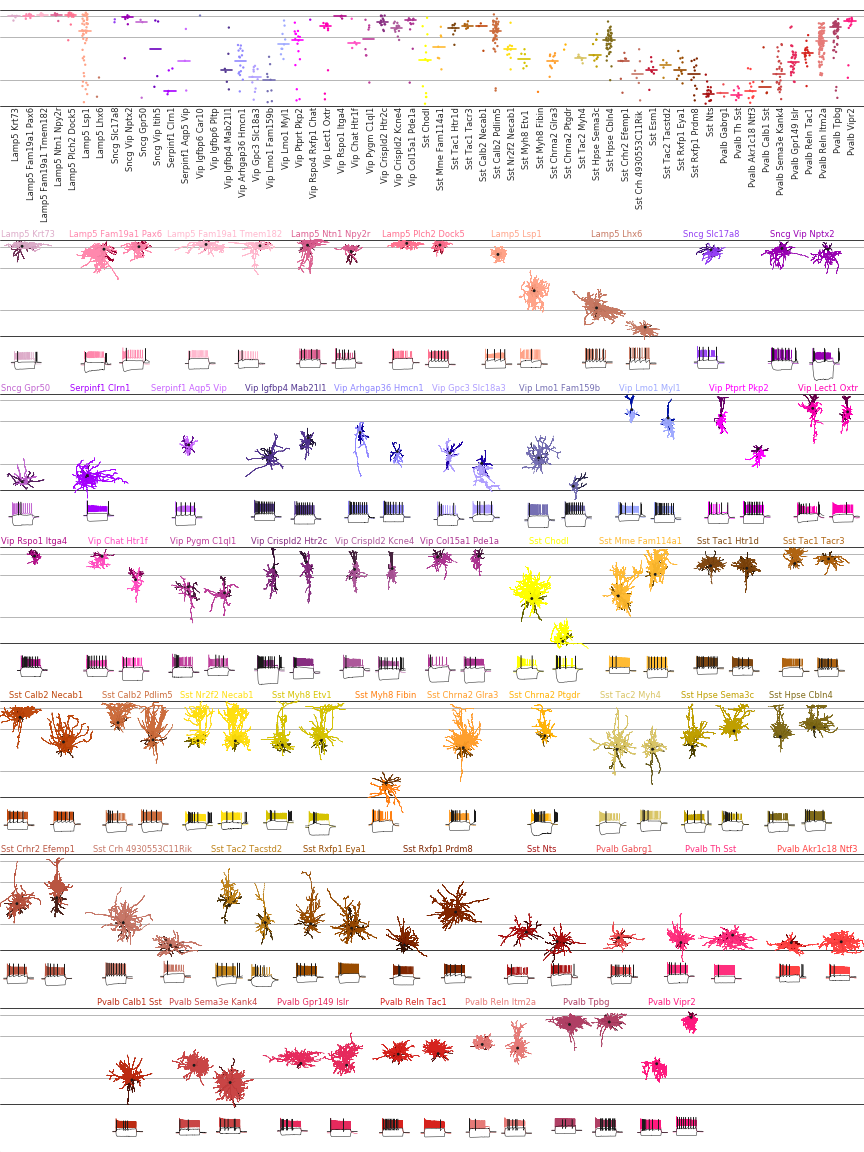

Width: 8.79 cortex thicknesses
Width: 9.00 cortex thicknesses
Width: 8.84 cortex thicknesses
Width: 8.73 cortex thicknesses
Width: 9.03 cortex thicknesses
Plotted 99 neurons in 55 types.


In [13]:
tasic2018 = pickle.load(open('../data/processed/reduced-allen-data/tasic2018.pickle', 'rb'))

ephys_width = 0.35
gap = 0.02
rows = 7
cells_per_type = 2
typerowgaps = [0, .22,.19,.15,.09,.1,.1]
rowoffsets = [0, 0, 0, 0, 0, 0, 1, 0]

h = 9.6
extratopspace = (h - 7.2/9*1.6 * rows)/h
plt.figure(figsize=(7.2, h))
startnewaxis = True
currentrow = 1

counter_neurons = 0
counter_types = 0

# Tasic-2018 has 60 interneuron types
for typ in np.arange(60):
    selection = m1.traced & (ttypes['tasic_ass']==typ) & (m1.exclude == '')
    if np.sum(selection)==0:
        continue
        
    col = tasic2018['clusterColors'][typ]
    ax_col = col
    den_col = [adjust_lightness(col,.4)]
        
    if startnewaxis:
        ax = plt.axes([0, (rows-currentrow-1)/rows * (1-extratopspace), 1, (1-extratopspace)/rows])
        plt.ylim([-1.5,0.1])
        plt.xlim([0,9])
        plt.gca().set_aspect('equal', adjustable='box')
        
        plt.xticks([])
        plt.yticks([])
        sns.despine(ax=ax, left=True, bottom=True)
        for y in [0,1]:
            plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='k')
        for y in [0.07,0.29,0.73]:
            plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')

        w = rowoffsets[currentrow]
        startnewaxis = False
        
    type_center = w
    counter_types += 1
    
    if np.sum(selection)==1:
        t = plt.text(1, -1, tasic2018['clusterNames'][typ], color=col, fontsize=5)
        bb = t.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
        labelwidth = bb.transformed(ax.transData.inverted()).width
        t.remove()
        minwidth = max(labelwidth+gap, ephys_width+gap)
    else:
        minwidth = ephys_width+gap
    
    if np.sum(selection[example_neurons_tasic])>=cells_per_type:
        mychoice = [e for e in example_neurons_tasic if selection[e]][:cells_per_type]
    else:
        mychoice = np.where(selection)[0][:cells_per_type]
        
    for i in mychoice:
        width = plot_swc(swcfiles[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=minwidth,
                          axon_color=ax_col, dendrite_color=den_col, soma_color='none')
        if m1.cells[i] in three_traces:
            time = three_traces[m1.cells[i]][:,3]
            traces = three_traces[m1.cells[i]][:,:3]
            timeinterval = time<=.9
            time = time[timeinterval]
            traces = traces[timeinterval,:]
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,2]/700 - 1.2, color=col, linewidth=.3,
                    rasterized=True)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,1]/700 - 1.2, color='k', linewidth=.3,
                    rasterized=True)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,0]/700 - 1.2, color='k', linewidth=.3,
                    rasterized=True)
            
        w += width
        type_center += width/2
        counter_neurons += 1
        
    plt.text(type_center, 0.03, tasic2018['clusterNames'][typ], color=col, fontsize=5, ha='center')
        
    if w>8.2:
        startnewaxis = True
        currentrow += 1
        print('Width: {:.2f} cortex thicknesses'.format(w))
        if currentrow > rows:
            break
    else:
        w += typerowgaps[currentrow]

print('Plotted {} neurons in {} types.'.format(counter_neurons, counter_types))

In [14]:
# Add depths

currentrow=0
ax = plt.axes([0, (rows-currentrow-1)/rows * (1-extratopspace)+extratopspace, 1, (1-extratopspace)/rows])
plt.ylim([-1.5,0.1])
        
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax, left=True, bottom=True)
for y in [0,1]:
    plt.plot([-1,60], [-y,-y], linewidth=.5, zorder=0, color='k')
for y in [0.07,0.29,0.73]:
    plt.plot([-1,60], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
    
np.random.seed(42)
for t in range(60):
    ind = (ttypes['tasic_ass']==t) & (m1.exclude=='') & ~np.isnan(m1.depth) & ~np.isnan(m1.thickness)
    d = -m1.depth[ind] / m1.thickness[ind]
    if d.size > 0:
        plt.scatter(t + np.random.uniform(-1,+1,size=d.size)/5, d, 
                    color=tasic2018['clusterColors'][t], s=2, edgecolor='none')
    if d.size >= 3:
        plt.plot(t + np.array([-.4,.4]), np.array([1,1]) * np.median(d),
                 color=tasic2018['clusterColors'][t], linewidth=1)
plt.xticks([])
plt.xlim([-1, 60])
plt.ylabel('Norm. soma depth', labelpad=6)

ax.tick_params(axis='x', which='major', pad=-28)
plt.xticks(np.arange(60)+.2, tasic2018['clusterNames'][:60], rotation=90, fontsize=5)
plt.gca().tick_params(axis='x', length=0)

ind = ~np.isnan(ttypes['tasic_ass']) & (m1.exclude=='') & ~np.isnan(m1.depth) & ~np.isnan(m1.thickness)
print('{} total cells in panel a'.format(np.sum(ind)))

plt.savefig('../figures/suppfigures/pokemons-tasic2018.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/pokemons-tasic2018_dpi300.pdf', dpi=300)
plt.savefig('../figures/suppfigures/pdf/pokemons-tasic2018_dpi600.pdf', dpi=600)

1187 total cells in panel a


## One batch (or some other group of cells)

<IPython.core.display.Javascript object>


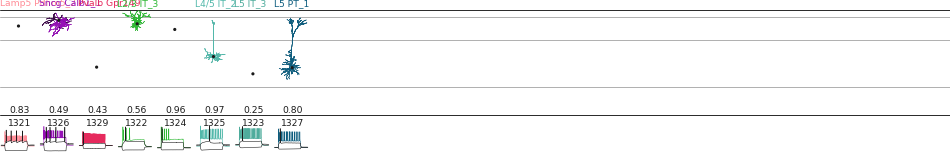

In [14]:
n = m1.exonCounts.shape[0]

ephys_width = 0.35
gap = 0.02

selection = (np.arange(n)>=1320)
rows = np.ceil(np.sum(selection) / 20)
plt.figure(figsize=(7.2, 7.2/9*1.6 * rows))
startnewaxis = True
currentrow = 0.0

for typ in range(clusterN):

    selection = (ttypes['type']==clusterNames[typ]) & (np.arange(n)>=1320)
    if np.sum(selection)==0:
        continue
    
    col = clusterColors[typ]
    if typ >= np.where(clusterNames=='L2/3 IT_1')[0][0]:
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
        
    showname = True
        
    for i in np.concatenate((np.where(m1.traced & selection)[0], np.where(~m1.traced & selection)[0])):
        if startnewaxis:
            ax = plt.axes([0, (rows-currentrow-1)/rows, 1, 1.0/rows])
            plt.ylim([-1.5,0.1])
            plt.xlim([0,9])
            plt.gca().set_aspect('equal', adjustable='box')
        
            plt.xticks([])
            plt.yticks([])
            sns.despine(ax=ax, left=True, bottom=True)
            for y in [0,1]:
                plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='k')
            for y in [0.07,0.29,0.73]:
                plt.plot([0,9], [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
            
            w = 0
            startnewaxis = False
    
        if m1.traced[i]:
            width = plot_swc(swcfiles[m1.cells[i]], ax=ax, depth=m1.depth[i], 
                          thickness=m1.thickness[i], offset=w, minwidth=ephys_width+gap,
                          axon_color=ax_col, dendrite_color=den_col, soma_color='none')
        else:
            ax.scatter(w + ephys_width/2, -m1.depth[i]/m1.thickness[i], s=3, c='k', edgecolors='none')
            width = ephys_width+gap
    
        if m1.cells[i] in three_traces:
            time = three_traces[m1.cells[i]][:,3]
            traces = three_traces[m1.cells[i]][:,:3]
            timeinterval = time<=.9
            time = time[timeinterval]
            traces = traces[timeinterval,:]
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,2]/700 - 1.2, color=col, linewidth=.3)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,1]/700 - 1.2, color='k', linewidth=.3)
            plt.plot((time-.5)*ephys_width + w + width/2, traces[:,0]/700 - 1.2, color='k', linewidth=.3)
            
        plt.text(w + width/2, -0.98, '{:.2f}'.format(ttypes['confidence'][i]),
                 color='k', fontsize=5, ha='center')
        plt.text(w + width/2, -1.1, i+1, color='k', fontsize=5, ha='center')
    
        if showname:
            plt.text(w, 0.03, clusterNames[typ], color=col, fontsize=5, ha='left')
            showname = False
            
        w += width
        
        if w>8.2:
            startnewaxis = True
            currentrow += 1
            assert currentrow <= rows, "Not enough rows!"
            
    bbox = None
    if currentrow < rows-1:
         bbox =  matplotlib.transforms.Bbox([[0, 7.2/9*1.6],[7.2, 7.2/9*1.6 * rows]])
        
#     plt.savefig('figures/pretty_neurons/batch-11.png', dpi=300, bbox_inches=bbox)